# Importing dependencies

In [1]:
import numpy as np
import pandas as pd
from os import path, listdir

import matplotlib.pyplot as plt
%matplotlib inline

# Directories

In [2]:
# Data directories:

# On PC:
#exoplanets_dir = path.expanduser("~/OneDrive/SEPHI_data/exoplanets/")
#W20_st_dir = path.expanduser("~/OneDrive/W20_data/")

# On my laptop:
exoplanets_dir = path.expanduser("~/Scarlett/OneDrive - Liverpool John Moores University/SEPHI_data/exoplanets/")
#W20_st_dir = path.expanduser("~/Scarlett/OneDrive - Liverpool John Moores University/W20_data/") # Do I end up using this?

st_header_len = 61
W20_pl_dir = "../CKS_crossmatch/planetdata_200806.csv" 

# The date that the exoplanets data (NASA EA) was downloaded:
data_date = "2022_04_28"

# Read the data

## Read the exoplanets database

In [3]:
exoplanets = pd.read_csv(path.join(exoplanets_dir, f"exoplanets_psd_" + data_date + f".csv"))

## Read the W20 data

In [4]:
W20_data = pd.read_csv( W20_pl_dir ) #this data is pre cuts
#print(W20_data)

# Renaming W20 columns

# This is how I removed the f at the start of the planet data columns:
W20_cols = list(W20_data.columns.values)
#print(W20_cols)
# the only 'f' s in the col names are at the start
W20_cols_new = [i.replace("f", "") for i in W20_cols]
W20_cols_new[0] = "hostname" # was "hostnames"
#print(W20_cols_new)

# The output:
#W20_cols_new = ['hostname', 'pl_letter', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_age', 'st_ageerr1', 'st_ageerr2', 'st_met', 'st_meterr1', 'st_meterr2', 'st_dist', 'st_disterr1', 'st_disterr2', 'Nss', 'Pnull', 'BIC1', 'rhoN', 'Phigh', 'HJflag', 'insamp', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_smax', 'pl_smaxerr1', 'pl_smaxerr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_eccen', 'pl_eccenerr1', 'pl_eccenerr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_dens', 'pl_denserr1', 'pl_denserr2']
# insamp indicates whether the planet remains in the sample after cuts
# HJflag - are the Hot Jupiters around the star?
W20_cols_dict = {W20_cols[i]: W20_cols_new[i] for i in range(len(W20_cols))}
#print(W20_cols_dict)

# Renaming the columns:
W20_data.rename( columns=W20_cols_dict, inplace=True )
#print(W20_data.head())

# Reformatting the data

# Replace "-" entries with np.NaN
W20_data.replace(to_replace="-", value=np.nan, inplace=True)

# Changing the columns that should have numeric entries to numeric data types:
W20_numeric_cols = ['st_mass', 'st_masserr1', 'st_masserr2', 'st_age', 'st_ageerr1', 'st_ageerr2', 'st_met', 'st_meterr1', 'st_meterr2', 'st_dist', 'st_disterr1', 'st_disterr2', 'Pnull', 'BIC1', 'rhoN', 'Phigh', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_smax', 'pl_smaxerr1', 'pl_smaxerr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_eccen', 'pl_eccenerr1', 'pl_eccenerr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_dens', 'pl_denserr1', 'pl_denserr2']
W20_data[W20_numeric_cols] = W20_data[W20_numeric_cols].apply(pd.to_numeric)
#print(W20_data.dtypes)

# Separating the low and high phase-space densities

## For the exoplanets database

In [5]:
# Indicies of low and high phase-space density planets:
exo_low_index = np.where(exoplanets["class_6d"] == 0. )[0]
exo_amb_index = np.where(exoplanets["class_6d"] == 1. )[0]
exo_high_index = np.where(exoplanets["class_6d"] == 2.)[0]
# TODO: where are the exoplanets where Pnull > 0.05?

print("No. of exoplanets df planets in low phase-space density:", exo_low_index.size)
print("No. of exoplanets df planets in ambiguous phase-space density:", exo_amb_index.size)
print("No. of exoplanets df planets in high phase-space density:", exo_high_index.size)

No. of exoplanets df planets in low phase-space density: 431
No. of exoplanets df planets in ambiguous phase-space density: 365
No. of exoplanets df planets in high phase-space density: 843


## Performing the cuts on the exoplanets df

In [6]:
# Bearing in mind that my list of stars are only host stars (and it's the exoplanet list so some stars are repeated)
# Is it not as if the cuts have already been performed? Because Michal only calculated pahse space densities for stars that made it through the cuts?
# And I'm only plotting the stars that he calculated phase-space density for!

# 1. Remove stars with parallax / paralax_err > 4.5
#gaia = gaia[4.5 < gaia["parallax"] / gaia["parallax_error"]] #removes stars with with parallax/parallax error > 4.5

# 2. Calculate distance in pc and drop any stars with negative or null distance
#gaia["distance_pc"] = (1. / gaia["parallax"]) * 1000 
#closely aligned sources are only occasionally resolved in Gaia, confusion in observation-to-source matching can lead to spurious parallax values which are either very large or have a negative value very far away from zero
#gaia = gaia[gaia["distance_pc"] > 0] 
#returns all of gaia for which distance_pc > 0 and overwrites the gaia df with it. Gets rid of all entries where distance_pc <= 0. For these entries, the solution returned by gaia is unphysical so we want to ditch it

# 3. Convert from degrees to pc
#gaia["ra"] = (gaia["ra"] * np.pi) / 180.
#gaia["dec"] = (gaia["dec"] * np.pi) / 180.

## Cut in stallar mass (0.7 - 2 M_solar)

In [7]:
# Cuts in age: 1-4.5 Gyr
# How do they do the cut in age when so few agaes are available?
# Cuts in stellar mass: 0.7 - 2 M_solar

# TODO: work on finding 'best' params method first

#exoplanets_cut = np.where( np.isfinite(exoplanets["st_age"]) & (exoplanets["st_age"] >= 1.) & (exoplanets["st_age"] <= 4.5) & (exoplanets["st_mass"] <= 2.) )
#print(exoplanets_cut)

In [8]:
import sys 
sys.path.append('..')
from preprocessing.analyse_errs import get_best_values

# The best values for the masses:
masses = get_best_values(exoplanets, 'st_mass') # excludes masses where none of the calatogues have both +ve and -ve errors available
# The best values for stellar ages:
ages = get_best_values(exoplanets, 'st_age')
# TODO: print the no. of non-nan ages


# The indicies of the masses which make the cut:
masses_c1 = np.where( np.isfinite(masses) & (masses >= 1.) & (masses <= 4.5) )[0]
print('length of masses_c1:', len(masses_c1))
ages_c1 = np.where( (ages <= 4.5) & (ages >= 1.) )[0]
print('length of ages_c1:', len(ages_c1))
# TODO: this isn't right. Test st_age method in crossmathing_catalogues

cuts_index = np.intersect1d(masses_c1, ages_c1)
print('Number of exoplanets post cuts:', cuts_index.size)

# TODO: how many of those exoplanets have psds?
in_exo_sample = np.where( exoplanets['class_6d'].iloc[cuts_index].notnull() )[0]
print('Number of exoplanets post cuts with phase-space densities (the no. in my sample):', in_exo_sample.size)

# Indicies of low and high phase-space density planets after cuts:
# np.intersect1d -> the indicies in exo_low_index and masses_c1 that overlap
exo_low_index_cut = np.intersect1d(exo_low_index, cuts_index) 
exo_amb_index_cut = np.intersect1d(exo_amb_index, cuts_index) 
exo_high_index_cut = np.intersect1d(exo_high_index, cuts_index)

print("No. of exoplanets in low phase-space density:", exo_low_index_cut.size)
print("No. of exoplanets in ambiguous phase-space density:", exo_amb_index_cut.size)
print("No. of exoplanets in high phase-space density:", exo_high_index_cut.size)

length of masses_c1: 1852
length of ages_c1: 1343
Number of exoplanets post cuts: 827
Number of exoplanets post cuts with phase-space densities (the no. in my sample): 236
No. of exoplanets in low phase-space density: 24
No. of exoplanets in ambiguous phase-space density: 42
No. of exoplanets in high phase-space density: 170


In [9]:
# How come I have such a small sample?
# How did W20 constrain st_age?
# did they only use the stars with st_age listed?

# TODO: check how many st_mass flags come from NEA vs CKSII
# TODO: check how many st_age flags come from NEA vs CKSII
print(exoplanets)


         pl_name  hostname              gaia_designation  NEA_sy_snum  \
0       11 Com b    11 Com  Gaia DR2 3946945413106333696            2   
1       11 UMi b    11 UMi  Gaia DR2 1696798367260229376            1   
2       14 And b    14 And  Gaia DR2 1920113512486282240            1   
3       14 Her b    14 Her  Gaia DR2 1385293808145621504            1   
4     16 Cyg B b  16 Cyg B  Gaia DR2 2135550755683407232            3   
...          ...       ...                           ...          ...   
5009   ups And b   ups And   Gaia DR2 348020448377061376            2   
5010   ups And c   ups And   Gaia DR2 348020448377061376            2   
5011   ups And d   ups And   Gaia DR2 348020448377061376            2   
5012   ups Leo b   ups Leo  Gaia DR2 3794167001116433152            1   
5013    xi Aql b    xi Aql  Gaia DR2 4298361114750843904            1   

      NEA_sy_pnum NEA_discoverymethod  NEA_pl_period  NEA_pl_sma  \
0               1     Radial Velocity     326.030000   

## For the W20 data

In [10]:
# Indicies of low and high phase-space density planets:
# TODO: include p_null criterial in np.where() for the low_ and high_ index selections
W20_null_index = np.where(W20_data["Pnull"] > 0.05)[0]
W20_low_index = np.where(W20_data["Phigh"] < 0.16)[0]
W20_amb_index = np.where( (W20_data["Phigh"] > 0.16) & (W20_data["Phigh"] < 0.84) )[0]
W20_high_index = np.where(W20_data["Phigh"] > 0.84)[0]

print("No. of W20 planets with P_null > 0.05:", W20_null_index.size)
print("No. of W20 planets in low phase-space density:", W20_low_index.size)
print("No. of W20 planets in ambiguous phase-space density:", W20_amb_index.size)
print("No. of W20 planets in high phase-space density:", W20_high_index.size)

# The indicies of planets that remain in the W20 sample after cuts:
in_sample = np.where(W20_data["insamp"] == "Y" )[0]

# Indicies of low and high phase-space density planets after cuts:
W20_null_index_cut = np.intersect1d(W20_null_index, in_sample)
W20_low_index_cut = np.intersect1d(W20_low_index, in_sample)
W20_amb_index_cut = np.intersect1d(W20_amb_index, in_sample)
W20_high_index_cut = np.intersect1d(W20_high_index, in_sample)

# TODO: how do these numbers look?

print("\nNo. of W20 planets included in their analysis:", in_sample.size)
print("No. of W20 planets with P_null > 0.05:", W20_null_index_cut.size)
print("No. of W20 planets in low phase-space density:", W20_low_index_cut.size)
print("No. of W20 planets in ambiguous phase-space density:", W20_amb_index_cut.size)
print("No. of W20 planets in high phase-space density:", W20_high_index_cut.size)

No. of W20 planets with P_null > 0.05: 32
No. of W20 planets in low phase-space density: 369
No. of W20 planets in ambiguous phase-space density: 391
No. of W20 planets in high phase-space density: 762

No. of W20 planets included in their analysis: 523
No. of W20 planets with P_null > 0.05: 0
No. of W20 planets in low phase-space density: 61
No. of W20 planets in ambiguous phase-space density: 144
No. of W20 planets in high phase-space density: 318


# Plots

## Planet mass vs semi major axis pre cuts

Text(0.5, 0.01, 'log(a_p [AU])')

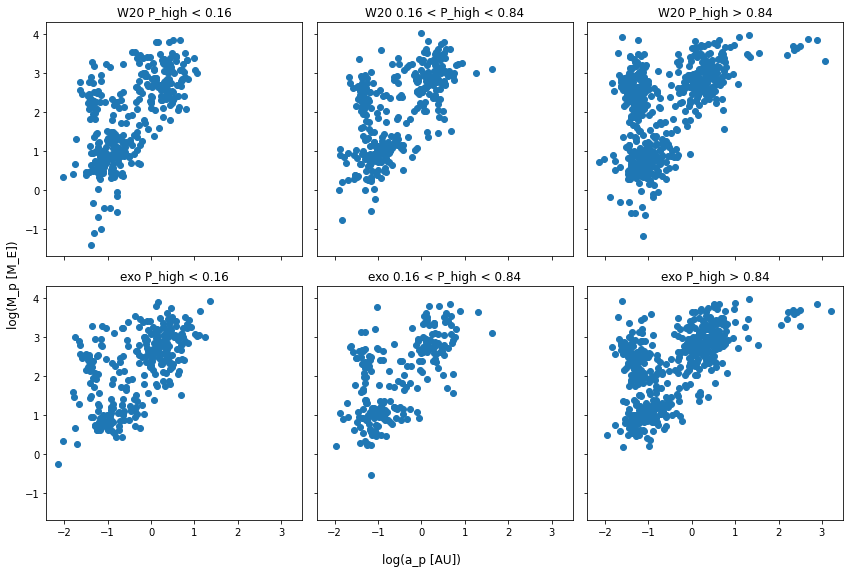

In [11]:
fig3, [[W20_ax_l, W20_ax_a, W20_ax_h], [exo_ax_l, exo_ax_a, exo_ax_h]] = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=[12,8], tight_layout=True)
# sharex makes them share the x-axis scale

W20_ax_l.set_title("W20 P_high < 0.16")
W20_ax_a.set_title("W20 0.16 < P_high < 0.84")
W20_ax_h.set_title("W20 P_high > 0.84")

exo_ax_l.set_title("exo P_high < 0.16")
exo_ax_a.set_title("exo 0.16 < P_high < 0.84")
exo_ax_h.set_title("exo P_high > 0.84")

# TODO: Does the table include hosts with P_null > 0.05?
W20_ax_l.scatter( np.log10(W20_data["pl_smax"].iloc[W20_low_index]), np.log10(W20_data["pl_bmasse"].iloc[W20_low_index]) )
W20_ax_a.scatter( np.log10(W20_data["pl_smax"].iloc[W20_amb_index]), np.log10(W20_data["pl_bmasse"].iloc[W20_amb_index]) )
W20_ax_h.scatter( np.log10(W20_data["pl_smax"].iloc[W20_high_index]), np.log10(W20_data["pl_bmasse"].iloc[W20_high_index]) )

exo_ax_l.scatter( np.log10(exoplanets["NEA_pl_sma"].iloc[exo_low_index]), np.log10(exoplanets["NEA_pl_mass"].iloc[exo_low_index]) )
exo_ax_a.scatter( np.log10(exoplanets["NEA_pl_sma"].iloc[exo_amb_index]), np.log10(exoplanets["NEA_pl_mass"].iloc[exo_amb_index]) )
exo_ax_h.scatter( np.log10(exoplanets["NEA_pl_sma"].iloc[exo_high_index]), np.log10(exoplanets["NEA_pl_mass"].iloc[exo_high_index]) )

fig3.supylabel('log(M_p [M_E])')
fig3.supxlabel('log(a_p [AU])')

# TODO: what happened to the planets at the bottom? did they get assigned Pnull?

## Planet mass vs semi major axis post cuts

Text(0.5, 0.01, 'log(a_p [AU])')

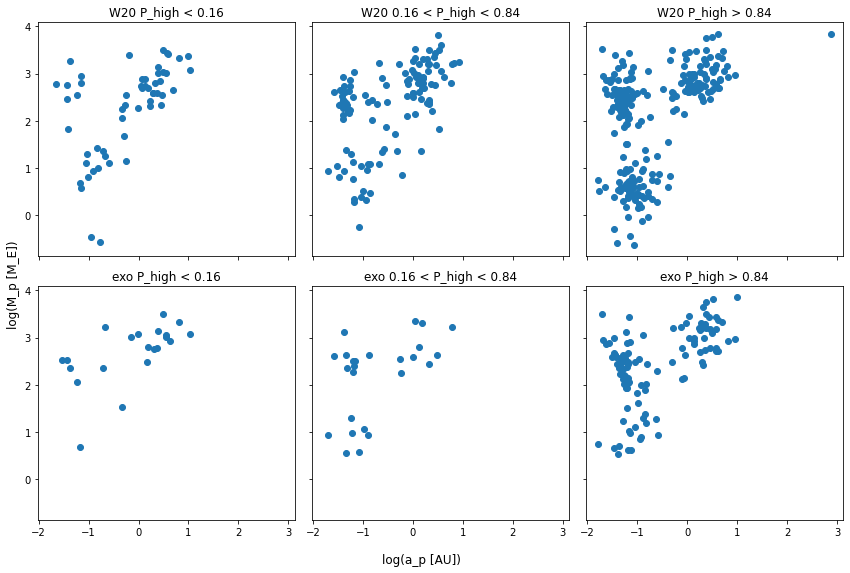

In [12]:
fig4, [[W20_ax_l, W20_ax_a, W20_ax_h], [exo_ax_l, exo_ax_a, exo_ax_h]] = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=[12,8], tight_layout=True)
# sharex makes them share the x-axis scale

# TODO: remember to cut Pnull > 0.05 in the W20 post cuts plots

# TODO: apply cuts to exoplanets df
W20_ax_l.set_title("W20 P_high < 0.16") # post cuts
W20_ax_a.set_title("W20 0.16 < P_high < 0.84")
W20_ax_h.set_title("W20 P_high > 0.84") # post cuts

exo_ax_l.set_title("exo P_high < 0.16") # pre cuts
exo_ax_a.set_title("exo 0.16 < P_high < 0.84")
exo_ax_h.set_title("exo P_high > 0.84") # pre cuts

W20_ax_l.scatter( np.log10(W20_data["pl_smax"].iloc[W20_low_index_cut]), np.log10(W20_data["pl_bmasse"].iloc[W20_low_index_cut]) )
W20_ax_a.scatter( np.log10(W20_data["pl_smax"].iloc[W20_amb_index_cut]), np.log10(W20_data["pl_bmasse"].iloc[W20_amb_index_cut]) )
W20_ax_h.scatter( np.log10(W20_data["pl_smax"].iloc[W20_high_index_cut]), np.log10(W20_data["pl_bmasse"].iloc[W20_high_index_cut]) )

exo_ax_l.scatter( np.log10(exoplanets["NEA_pl_sma"].iloc[exo_low_index_cut]), np.log10(exoplanets["NEA_pl_mass"].iloc[exo_low_index_cut]) )
exo_ax_a.scatter( np.log10(exoplanets["NEA_pl_sma"].iloc[exo_amb_index_cut]), np.log10(exoplanets["NEA_pl_mass"].iloc[exo_amb_index_cut]) )
exo_ax_h.scatter( np.log10(exoplanets["NEA_pl_sma"].iloc[exo_high_index_cut]), np.log10(exoplanets["NEA_pl_mass"].iloc[exo_high_index_cut]) )

fig4.supylabel('log(M_p [M_E])')
fig4.supxlabel('log(a_p [AU])')

In [50]:
"""
import matplotlib.ticker

# For the poster:
fig5, [exo_ax_l, exo_ax_h] = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=[12,6], tight_layout=True)

# Text sizing:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Formatting axis:
exo_ax_l.set_title("exo P_high < 0.16") # post cuts
exo_ax_h.set_title("exo P_high > 0.84") # post cuts

exo_ax_l.xaxis.set_major_locator(MultipleLocator(1))
#exo_ax_l.xaxis.set_major_formatter('{x:.0f}')
exo_ax_l.xaxis.set_minor_locator(MultipleLocator(0.1))

y_major = plt.ticker.LogLocator(base = 10.0, numticks = 5)
ax.yaxis.set_major_locator(y_major)
#exo_ax_l.yaxis.set_major_locator(MultipleLocator(1))
#exo_ax_l.yaxis.set_major_formatter('{x:.0f}')
y_minor = plt.ticker.LogLocator(base = 10.0, subs = numpy.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.yaxis.set_minor_locator(y_minor)
#exo_ax_l.yaxis.set_minor_locator(MultipleLocator(0.1))

exo_ax_l.tick_params(axis="both",direction="in", length=10, width=2, labelsize='large')
#exo_ax_h.tick_params(axis="x",direction="in")

# Plotting:
exo_ax_l.scatter( np.log10(exoplanets["NEA_pl_sma"].iloc[exo_low_index_cut]), np.log10(exoplanets["NEA_pl_mass"].iloc[exo_low_index_cut]) )
exo_ax_h.scatter( np.log10(exoplanets["NEA_pl_sma"].iloc[exo_high_index_cut]), np.log10(exoplanets["NEA_pl_mass"].iloc[exo_high_index_cut]) )

fig5.supylabel('log(M_p [M_E])')
fig5.supxlabel('log(a_p [AU])')
"""

'\nimport matplotlib.ticker\n\n# For the poster:\nfig5, [exo_ax_l, exo_ax_h] = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=[12,6], tight_layout=True)\n\n# Text sizing:\nSMALL_SIZE = 18\nMEDIUM_SIZE = 18\nBIGGER_SIZE = 22\n\nplt.rc(\'font\', size=SMALL_SIZE)          # controls default text sizes\nplt.rc(\'axes\', titlesize=SMALL_SIZE)     # fontsize of the axes title\nplt.rc(\'axes\', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels\nplt.rc(\'xtick\', labelsize=SMALL_SIZE)    # fontsize of the tick labels\nplt.rc(\'ytick\', labelsize=SMALL_SIZE)    # fontsize of the tick labels\nplt.rc(\'legend\', fontsize=SMALL_SIZE)    # legend fontsize\nplt.rc(\'figure\', titlesize=BIGGER_SIZE)  # fontsize of the figure title\n\n# Formatting axis:\nexo_ax_l.set_title("exo P_high < 0.16") # post cuts\nexo_ax_h.set_title("exo P_high > 0.84") # post cuts\n\nexo_ax_l.xaxis.set_major_locator(MultipleLocator(1))\n#exo_ax_l.xaxis.set_major_formatter(\'{x:.0f}\')\nexo_ax_l.xax

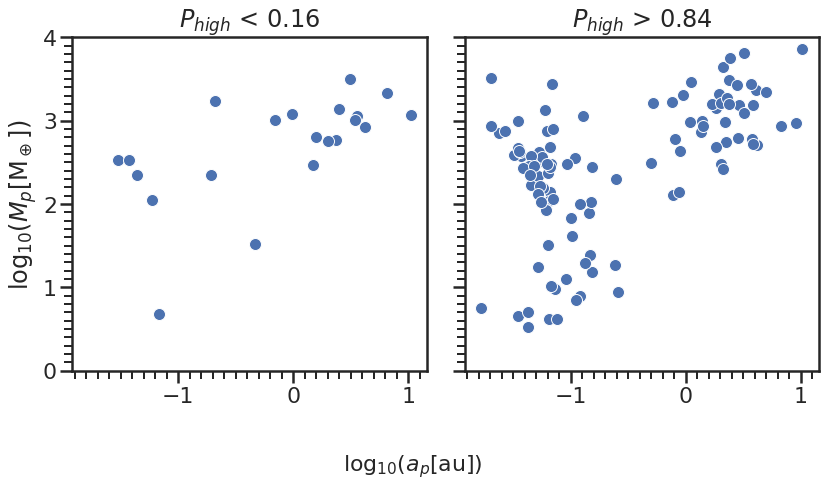

In [64]:
# For the poster using seaborn:
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

x1 = np.log10(exoplanets["NEA_pl_sma"].iloc[exo_low_index_cut])
y1 = np.log10(exoplanets["NEA_pl_mass"].iloc[exo_low_index_cut])
x2, y2 =  np.log10(exoplanets["NEA_pl_sma"].iloc[exo_high_index_cut]), np.log10(exoplanets["NEA_pl_mass"].iloc[exo_high_index_cut]) 

fig6, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=[12,7], tight_layout=True)

# Set style here:
sns.set(style='ticks')
sns.set_context("poster")
plt.ylim([0, 4])

#ax[0].set_xscale('log')
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].xaxis.set_minor_locator(MultipleLocator(0.1))

#ax[0].set_yscale('log')
ax[0].yaxis.set_major_locator(MultipleLocator(1))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))

# Plot data:
s1 = sns.scatterplot(x=x1, y=y1, palette="autumn", ax=ax[0])
s2 = sns.scatterplot(x=x2, y=y2, palette="autumn", ax=ax[1])

# Labels:
ax[0].set(xlabel=None, ylabel = r'$\log_{10}{(M_{p} [\rm M_\oplus])}$')
ax[0].set_title(r"$P_{high}$ < 0.16")

ax[1].set(xlabel=None)
ax[1].set_title(r"$P_{high}$ > 0.84")

fig6.supxlabel(r'$\log_{10}{(a_{p} [\rm au])}$', fontsize=22)
fig6.savefig('Mp_vs_ap.png')

In [62]:
import statistics as stat
x1 = exoplanets["NEA_pl_sma"].iloc[exo_low_index_cut]
y1 = exoplanets["NEA_pl_mass"].iloc[exo_low_index_cut]

x2, y2 =  (exoplanets["NEA_pl_sma"].iloc[exo_high_index_cut]), (exoplanets["NEA_pl_mass"].iloc[exo_high_index_cut]) 

# Mean of low psd = mean of x1:


# Mean of high psd = mean of x2:


print(x1.describe())
print(y1.describe())
print(x2.describe())
print(y2.describe())

count    22.000000
mean      2.010038
std       2.570718
min       0.030100
25%       0.139700
50%       1.231000
75%       2.950000
max      10.500000
Name: NEA_pl_sma, dtype: float64
count      22.000000
mean      854.626743
std       767.821689
min         4.820000
25%       306.626073
50%       613.411900
75%      1162.463225
max      3184.656600
Name: NEA_pl_mass, dtype: float64
count    127.000000
mean       0.934810
std        1.681542
min        0.016600
25%        0.058850
50%        0.107000
75%        1.230000
max       10.150000
Name: NEA_pl_sma, dtype: float64
count     117.000000
mean      812.200076
std      1255.096002
min         3.350000
25%        85.814100
50%       308.295100
75%       973.000000
max      7278.270520
Name: NEA_pl_mass, dtype: float64
